# Al Rahma Dinda S/3323600038/3-D4 Sains Data Terapan B

## Analisis Faktor yang Memengaruhi Tingkat Pengangguran Terbuka (TPT) di Jawa Timur Tahun 2023 dengan Model Regresi Probit

### Library

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

Menampilkan isi dataset

In [87]:
df = pd.read_excel("Dataset TPT Jatim 2023.xlsx")
df

,Kabupaten/Kota,TPT,TPAK,IPM,UMK
0,Pacitan,1.83,81.64,70.19,2157270.25
1,Ponorogo,4.66,75.88,72.50,2149709.45
2,Trenggalek,4.52,80.72,71.73,2139426.01
3,Tulungagung,5.65,74.70,74.61,2229358.67
4,Blitar,4.91,73.50,72.49,2215071.18
5,Kediri,5.79,68.74,73.96,2243422.93
6,Malang,5.70,70.66,72.16,3268275.36
7,Lumajang,3.67,68.49,67.87,2200607.20
8,Jember,4.01,72.30,68.64,2555662.91
9,Banyuwangi,4.75,79.04,72.61,2528899.12


Analisis Deskriptif

In [88]:
df.describe()

,TPT,TPAK,IPM,UMK
count,38.000000,38.000000,38.000000,3.800000e+01
mean,4.662895,73.159211,73.680263,2.694768e+06
std,1.428828,3.767150,5.053755,7.891471e+05
min,1.710000,66.890000,64.130000,2.114335e+06
25%,4.082500,70.242500,70.215000,2.157664e+06
50%,4.665000,72.495000,72.790000,2.261496e+06
75%,5.600000,75.230000,76.760000,2.828888e+06
max,8.050000,81.640000,83.450000,4.525479e+06


Mengecek tipe data

In [89]:
df.dtypes

Kabupaten/Kota     object
TPT               float64
TPAK              float64
IPM               float64
UMK               float64
dtype: object

### Visualisasi Distribusi Variabel

Menampilkan distribusi variabel utama (TPT, TPAK, IPM, UMK)

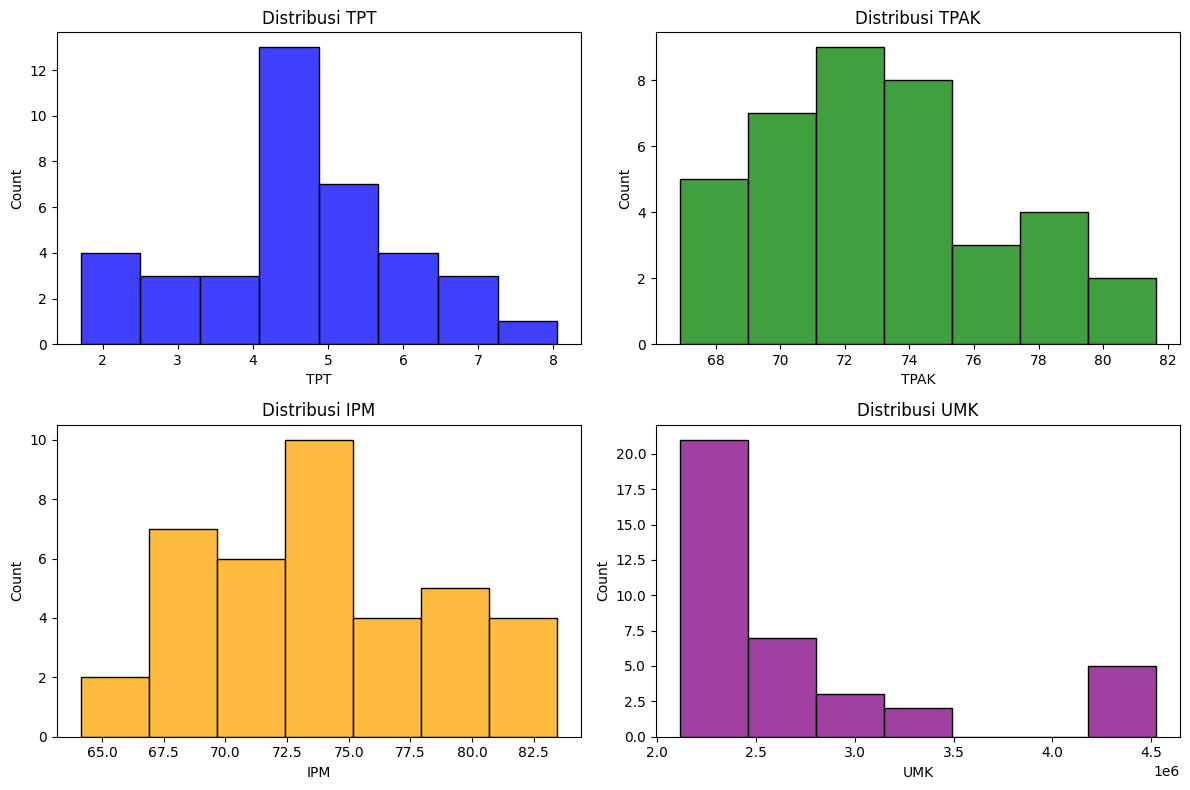

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.histplot(df['TPT'], ax=axes[0,0], color="blue"); axes[0,0].set_title("Distribusi TPT")
sns.histplot(df['TPAK'], ax=axes[0,1], color="green"); axes[0,1].set_title("Distribusi TPAK")
sns.histplot(df['IPM'], ax=axes[1,0], color="orange"); axes[1,0].set_title("Distribusi IPM")
sns.histplot(df['UMK'], ax=axes[1,1], color="purple"); axes[1,1].set_title("Distribusi UMK")
plt.tight_layout(); plt.show()

### Variabel Target

Membuat target biner: 
- 1 = TPT di atas rata-rata provinsi (Tinggi)
- 0 = TPT di bawah atau sama dengan rata-rata provinsi (Rendah)

In [91]:
# Menghitung rata-rata TPT provinsi
mean_TPT = df['TPT'].mean()
print("Rata-rata TPT Jatim 2023:", round(mean_TPT,2))

# Membuat variabel target berdasarkan rata-rata
df['TPT_Category'] = (df['TPT'] > mean_TPT).astype(int)

df[['Kabupaten/Kota','TPT','TPT_Category']]

Rata-rata TPT Jatim 2023: 4.66


,Kabupaten/Kota,TPT,TPT_Category
0,Pacitan,1.83,0
1,Ponorogo,4.66,0
2,Trenggalek,4.52,0
3,Tulungagung,5.65,1
4,Blitar,4.91,1
5,Kediri,5.79,1
6,Malang,5.70,1
7,Lumajang,3.67,0
8,Jember,4.01,0
9,Banyuwangi,4.75,1


### Transformasi Variabel

Menstabilkan skala UMK (dipakai di model, bukan untuk visualisasi)

In [92]:
df['log_UMK'] = np.log(df['UMK'])

### Mendefinisikan Variabel 

Menentukan variabel independen (TPAK, IPM, log_UMK) dan target (TPT_high)

In [93]:
X = df[['TPAK','IPM','log_UMK']]
X = sm.add_constant(X)   
y = df['TPT_Category']

Menampilkan distribusi target

In [94]:
df['TPT_Category'].value_counts()

TPT_Category
0    19
1    19
Name: count, dtype: int64

Menampilkan rata-rata variabel numerik berdasarkan kategori target

In [95]:
df.groupby('TPT_Category').mean(numeric_only=True)

,TPT,TPAK,IPM,UMK,log_UMK
TPT_Category,,,,,
0,3.625789,74.631053,71.278421,2.356937e+06,14.665964
1,5.700000,71.687368,76.082105,3.032600e+06,14.879607


### Estimasi Model Probit (Maximum Likelihood Estimation)

Estimasi model probit dan menampilkan hasil koefisien, z-stat, p-value

In [96]:
model = Probit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.483999
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:           TPT_Category   No. Observations:                   38
Model:                         Probit   Df Residuals:                       34
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.3017
Time:                        21:27:41   Log-Likelihood:                -18.392
converged:                       True   LL-Null:                       -26.340
Covariance Type:            nonrobust   LLR p-value:                  0.001191
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.3190     20.006     -1.366      0.172     -66.530      11.892
TPAK          -0.1138      0.

### Marginal Effects

Menghitung marginal effect (pengaruh perubahan 1 unit X terhadap probabilitas Y=1)

In [97]:
mfx = model.get_margeff(at='overall', method='dydx')
print(mfx.summary())

       Probit Marginal Effects       
Dep. Variable:           TPT_Category
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TPAK          -0.0307      0.017     -1.835      0.067      -0.063       0.002
IPM            0.0297      0.013      2.258      0.024       0.004       0.056
log_UMK        0.5035      0.328      1.535      0.125      -0.139       1.146


### Goodness-of-fit: Pseudo R² (McFadden)

Menghitung pseudo R-squared untuk menilai goodness of fit

In [98]:
llf = model.llf       # log-likelihood model
llnull = model.llnull # log-likelihood model kosong
pseudo_r2 = 1 - (llf/llnull)
print("Pseudo R-squared (McFadden):", round(pseudo_r2,3))

Pseudo R-squared (McFadden): 0.302


### Validasi Model

Membandingkan hasil prediksi dengan data aktual

In [99]:
df['pred_prob'] = model.predict(X)                     # probabilitas prediksi
df['pred_class'] = (df['pred_prob'] > 0.5).astype(int) # klasifikasi biner (threshold 0.5)

# Confusion Matrix
cm = confusion_matrix(y, df['pred_class'])
print("Confusion Matrix:\n", cm)

# AUC Score
auc = roc_auc_score(y, df['pred_prob'])
print("\nAUC:", round(auc,3))

# Classification Report
print("\nClassification Report:\n", classification_report(y, df['pred_class']))

Confusion Matrix:
 [[14  5]
 [ 5 14]]

AUC: 0.837

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74        19
           1       0.74      0.74      0.74        19

    accuracy                           0.74        38
   macro avg       0.74      0.74      0.74        38
weighted avg       0.74      0.74      0.74        38



### ROC Curve

Menampilkan kurva ROC

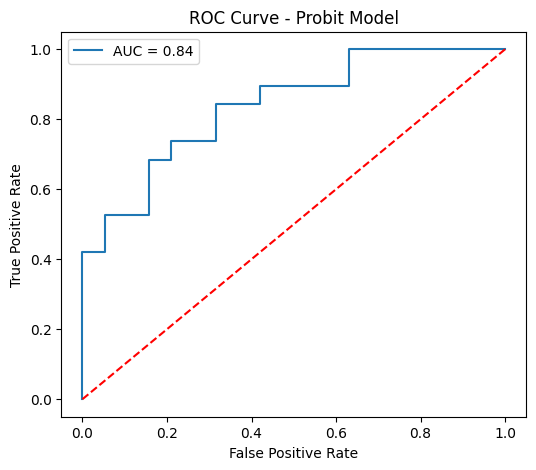

In [100]:
fpr, tpr, thresholds = roc_curve(y, df['pred_prob'])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'--',color='red')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Probit Model"); plt.legend(); plt.show()